In [1]:
import numpy as np
import pandas as pd
from fastai.vision.all import *
from pathlib import Path
from functools import partial
import torch.nn as nn

In [2]:
path = Path('../data/')
train = pd.read_csv(path / 'train.csv')
test = pd.read_csv(path / 'test.csv')
submission = pd.read_csv(path / 'sample_submission.csv')

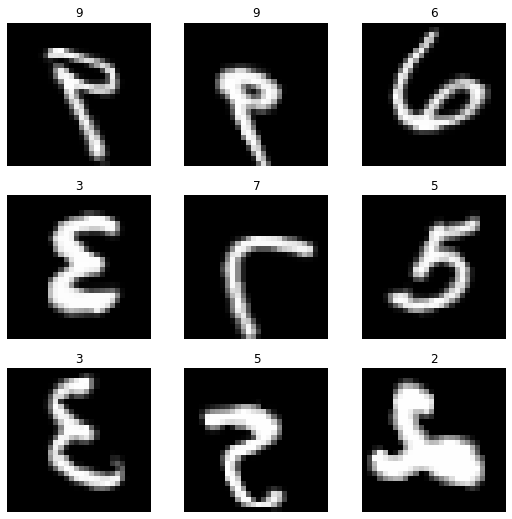

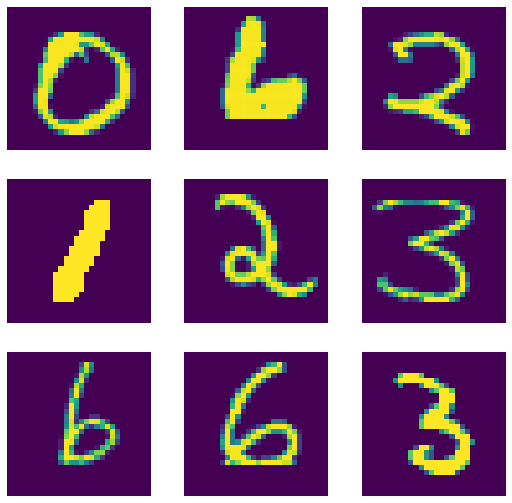

In [3]:
def get_digits(row, has_label=True):
    
    if has_label: row = row.drop('label')
    return np.uint8(row.values.reshape(28,28))

def get_label(row):
    
    return row['label']

data_block_train = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       get_x = get_digits,
                       get_y = get_label,
                       splitter = RandomSplitter(seed = 123),
                       batch_tfms = [*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
                      )
dataloader_train = data_block_train.dataloaders(train)
dataloader_train.show_batch()

data_block_test = DataBlock(blocks=(ImageBlock,),
                       get_x = partial(get_digits, has_label=False),
                       batch_tfms = [ Normalize.from_stats(*imagenet_stats)]
                      )
dataloader_test = data_block_test.dataloaders(test)
dataloader_test.show_batch()

In [16]:
learner = cnn_learner(dataloader_train, resnet50, metrics=accuracy)

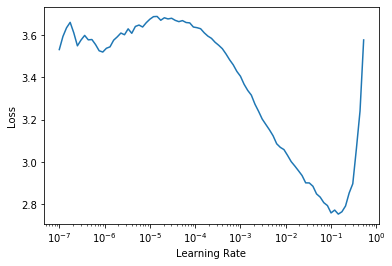

In [5]:
lr_min, lr_steep = learner.lr_find()

In [17]:
learner.fine_tune(5, base_lr=lr_steep)

In [8]:
def FlatCosAnnealScheduler(self:Learner, lr:float=4e-3, tot_epochs:int=1, start_pct:float=0.72,
                           curve='cosine'):
    n = len(self.dls.train)
    anneal_start = int(n * tot_epochs * start_pct)
    batch_finish = ((n * tot_epochs) - anneal_start)
    if curve=="cosine":        curve_sched=SchedCos(lr, 0)
    elif curve=="linear":      curve_sched=SchedLin(lr, 0)
    elif curve=="exponential": curve_sched=SchedExp(lr, 0)
    else: raiseValueError(f"annealing type not supported {curve}")
    scheds = [SchedNo(lr, start_pct), curve_sched]
    scheds = {'lr': combine_scheds([start_pct, 1-start_pct], scheds)}
    return scheds

In [19]:
def convert_act_cls(model, layer_type_old, layer_type_new):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_act_cls(module, layer_type_old, layer_type_new)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = layer_type_new
            model._modules[name] = layer_new

    return model

In [20]:
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):  
        #save 1 second per epoch with no x= x*() and then return x...just inline it.
        return x *( torch.tanh(F.softplus(x))) 

In [21]:
opt_func = ranger
loss_func = LabelSmoothingCrossEntropy()

learner2 = cnn_learner(dataloader_train, resnet50, opt_func=opt_func,
             metrics=[accuracy],
             loss_func = loss_func)

learner2.model = convert_act_cls(learner2.model, nn.ReLU, Mish())

callbacks = ParamScheduler(FlatCosAnnealScheduler(learner2, lr_steep, tot_epochs=5))

learner2.fine_tune(10, base_lr=lr_steep, cbs=callbacks)

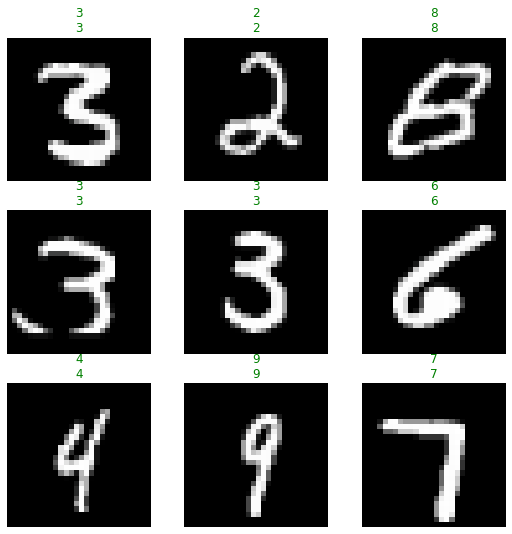

In [68]:
learner2.show_results()

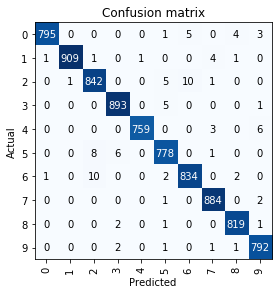

In [69]:
interp = ClassificationInterpretation.from_learner(learner2)
interp.plot_confusion_matrix()

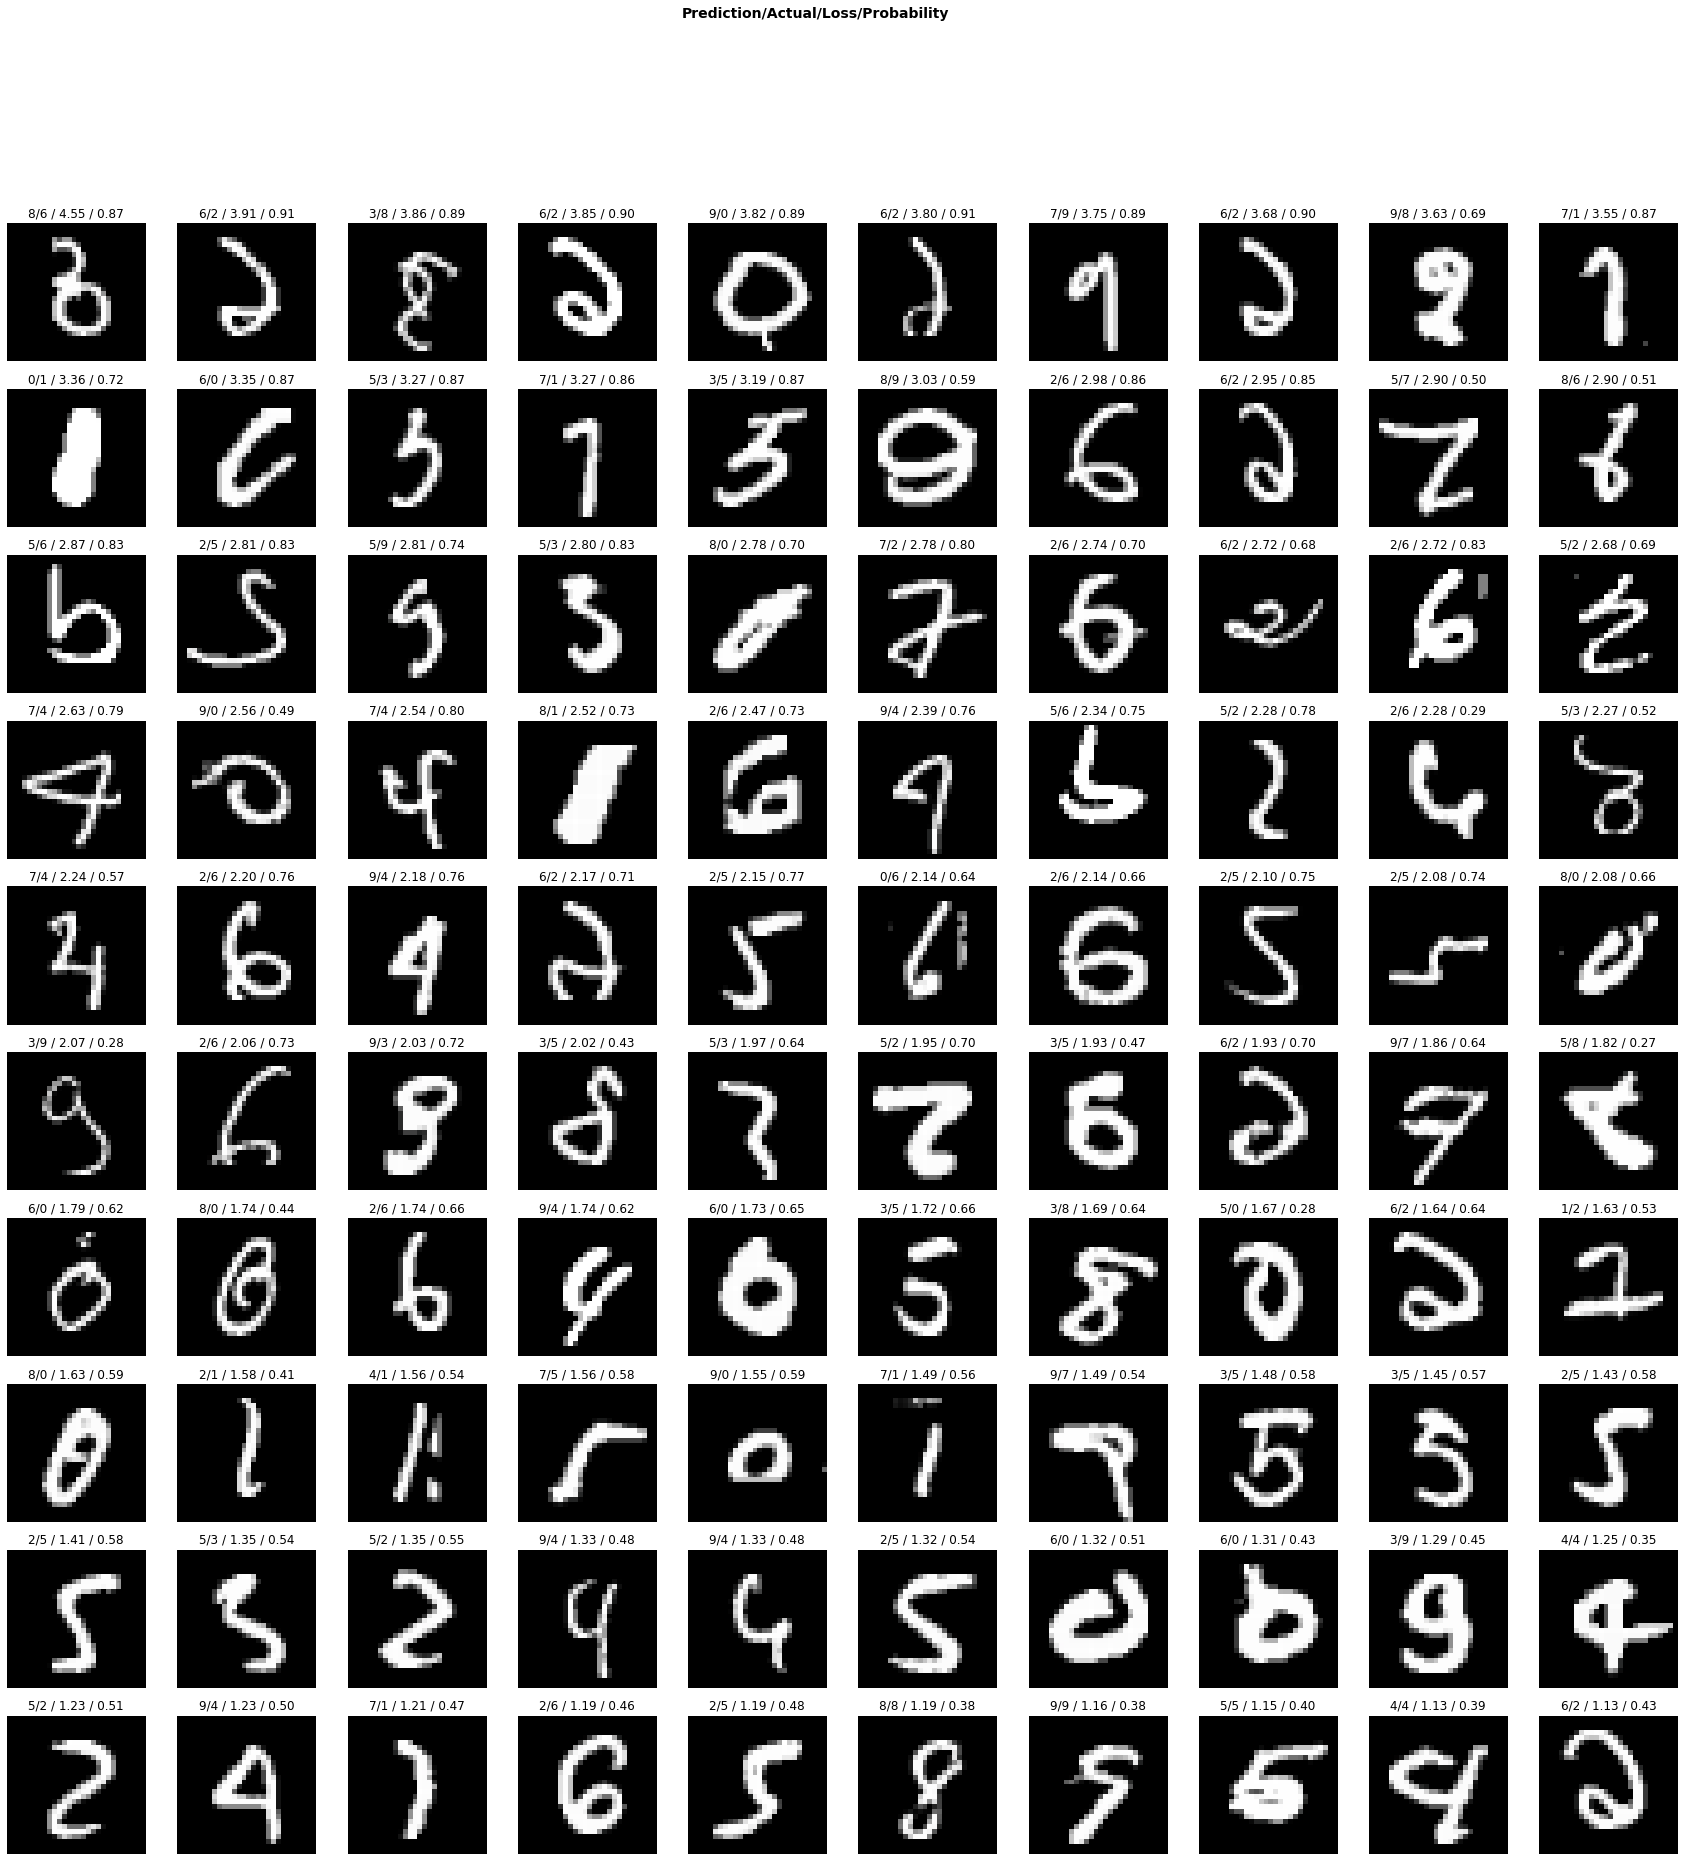

In [70]:
interp.plot_top_losses(100)

In [79]:
test

pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0           0       0       0       0       0       0       0       0       0   
1           0       0       0       0       0       0       0       0       0   
2           0       0       0       0       0       0       0       0       0   
3           0       0       0       0       0       0       0       0       0   
4           0       0       0       0       0       0       0       0       0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
27995       0       0       0       0       0       0       0       0       0   
27996       0       0       0       0       0       0       0       0       0   
27997       0       0       0       0       0       0       0       0       0   
27998       0       0       0       0       0       0       0       0       0   
27999       0       0       0       0       0       0       0       0       0   

       pixel9  ...  pixel774  pixel775  pixel776  pixel777  pixel778  \
0           0  ...         0         0         0         0         0   
1           0  ...         0         0         0         0         0   
2           0  ...         0         0         0         0         0   
3           0  ...         0         0         0         0         0   
4           0  ...         0         0         0         0         0   
...       ...  ...       ...       ...       ...       ...       ...   
27995       0  ...         0         0         0         0         0   
27996       0  ...         0         0         0         0         0   
27997       0  ...         0         0         0         0         0   
27998       0  ...         0         0         0         0         0   
27999       0  ...         0         0         0         0         0   

       pixel779  pixel780  pixel781  pixel782  pixel783  
0             0         0         0         0         0  
1             0         0         0         0         0  
2             0         0         0         0         0  
3             0         0         0         0         0  
4             0         0         0         0         0  
...         ...       ...       ...       ...       ...  
27995         0         0         0         0         0  
27996         0         0         0         0         0  
27997         0         0         0         0         0  
27998         0         0         0         0         0  
27999         0         0         0         0         0  

[28000 rows x 784 columns]

In [125]:
test_data = np.apply_along_axis(lambda x: Normalize.from_stats(*imagenet_stats)(x.reshape(28,28)).astype(np.uint8), 1, test)
for i in range(test.shape[0]):
    label, _, logits = learner2.predict(test_data[i])
    submission.loc[i, 'Label'] = int(label)
submission.to_csv('submission_v3.csv', index=None)